Using the dataset `hsb2.txt` find the linearmodel of all the scores on `science`. Then :

 * Explain the goodness of fit and the value of the RSE
 * Find if the impact of `read` is the same as the impact of `write`
 * Find if the grades in *humanities* are relevant to explain the variability in `science`

In [1]:
# Base -----------------------------------
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm

# Viz ------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')

# Models ---------------------------------
from statsmodels.formula.api import ols
import statsmodels.stats.anova as aov
import statsmodels.stats.diagnostic as ssd
import statsmodels.stats.outliers_influence as sso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
from scipy.stats import mstats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('IEXL')

Mounted at IEXL


In [4]:
grades = pd.read_csv('/content/IEXL/MyDrive/IEXL - Bootcamp - Math&Stats/Data Sets/hsb2.txt', sep='\t')
grades.head()

,id,gender,race,ses,schtyp,prog,read,write,math,science,socst
0,70,male,white,low,public,general,57,52,41,47,57
1,121,female,white,middle,public,vocational,68,59,53,63,61
2,86,male,white,high,public,general,44,33,54,58,31
3,141,male,white,high,public,vocational,63,44,47,53,56
4,172,male,white,middle,public,academic,47,52,57,53,61


## Model

In [5]:
model = ols('science ~ read + write + math', data=grades).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     65.32
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           2.54e-29
Time:                        10:02:30   Log-Likelihood:                -672.51
No. Observations:                 200   AIC:                             1353.
Df Residuals:                     196   BIC:                             1366.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4074      3.193      2.633      0.0

In [6]:
fitted = model.fittedvalues
residuals = model.resid
abs_resids = np.abs(residuals)

n = model.nobs
K = len(model.model.exog[0])-1

RSE = np.sqrt(sum(residuals**2)/(n-K-1))
print('The residual standard error is', RSE)
print('The adjusted R2 is', model.rsquared_adj)

The residual standard error is 7.054757381626817
The adjusted R2 is 0.49229010683019414


In [ ]:
restricted = ols('science ~ math', data=grades).fit()
aov.anova_lm(restricted, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,198.0,11746.942091,0.0,NaN,NaN,NaN
1,196.0,9754.841936,2.0,1992.100155,20.013222,1.232963e-08


In [6]:
hypo = '(read=0), (write=0)'
model.f_test(hypo)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[20.01322179]]), p=1.232963055374172e-08, df_denom=196, df_num=2>

In [7]:
grades['compr'] = grades['read']+grades['write']
model_2=ols('science ~ math + read + compr', data=grades).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     65.32
Date:                Tue, 16 Mar 2021   Prob (F-statistic):           2.54e-29
Time:                        15:58:36   Log-Likelihood:                -672.51
No. Observations:                 200   AIC:                             1353.
Df Residuals:                     196   BIC:                             1366.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4074      3.193      2.633      0.0

## Validation



### Multicollinearity

In [7]:
corr_df = grades[['read', 'write', 'math', 'socst']].corr()**2
corr_df.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

,read,write,math,socst
read,1.00,0.36,0.44,0.39
write,0.36,1.00,0.38,0.37
math,0.44,0.38,1.00,0.30
socst,0.39,0.37,0.30,1.00


In [8]:
X = grades[['read', 'write', 'math', 'socst']]
X['Intercept'] = 1

vif = pd.DataFrame()
vif['variables'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

   variables        VIF
0       read   2.224411
1      write   2.002221
2       math   2.085302
3      socst   1.911425
4  Intercept  41.774589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We do not detect any problems with multicollinearity, then we proceed with the model as we had it.

### Linearity

We are going to perform a Ramsey's RESET test with an unrestricted model given by

$$
\hat y_i = \beta_o+\beta_1\,x_1+\beta_2\, x_2 + \hat y_i^n
$$

In [9]:
sso.reset_ramsey(model, degree=2)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.83027508]]), p=0.1776615490734271, df_denom=195, df_num=1>

The decision scheme is

$$
H_0:\{\text{linearity}\}
$$

then since the p-value is $0.1777$ we fail to reject the null hypothesis and we do not find any evidence against the linear specification of the model

### Zero Expected Value and Normality

Remember that this is a property required to the residuals, which must be distributed as $N(0,\sigma)$

In [10]:
residuals.mean()

8.988365607365267e-15

We see that $E[\hat e]=0$, then let's now test for normality. We can use

 * Shapiro-Wilk
 * D'Agostino
 * Jarque-Bera 

tests and consider that as soon as one of them fails, normality fails.

In [11]:
s_stats, s_pval = ss.shapiro(residuals)
d_stats, d_pval = ss.normaltest(residuals)

s_pval, d_pval

(0.75171959400177, 0.42369009024567483)

since the decision scheme is

$$
H_0:\{\text{normality}\}
$$

and since all the three p-values we find are way larger than 0.05, then we don't find evidence against normality.

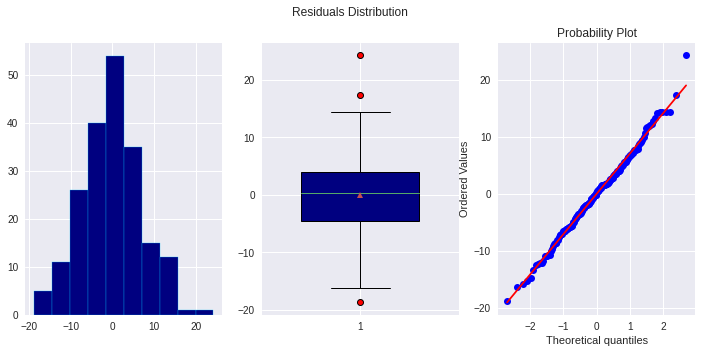

In [12]:
plt.figure(figsize=(12,5))
plt.suptitle('Residuals Distribution')

plt.subplot(1,3,1)
plt.hist(residuals,
         color='navy',
         ec = 'deepskyblue')

plt.subplot(1,3,2)
plt.boxplot(residuals,
            patch_artist = True,
            widths=0.6,
            showmeans=True,
            boxprops=dict(facecolor='navy'),
            flierprops=dict(marker = 'o',
                            markerfacecolor='red'))

plt.subplot(1,3,3)
ss.probplot(residuals, plot=sns.mpl.pyplot)

plt.show()

### Heteroskedasticity

We can use:

 * **White** test
 * **Breusch-Pagan** test



In [13]:
Mult, Lpval, Fstat, Fpval = ssd.het_white(residuals, model.model.exog)
Fpval

0.06354296499664744

In [14]:
Mult, Lpval, Fstat, Fpval = ssd.het_breuschpagan(residuals, model.model.exog)
Fpval

0.47215000568992127

Since the decision scheme is 

$$
H_0:\{\text{Homoskedasticity}\}
$$

then with a p-value of 0.63, we do not find any evidence against homoskedasticity, and all the variances can be assumed to be equal

Suppose that we where working under a 10% and the White-test forces us to assume that there is a problem with heteroskedasticity, what can we do? A graphical understanding of the situation can be gained by plotting the residuals vs. each independent variable to see if any of the graphs is not random

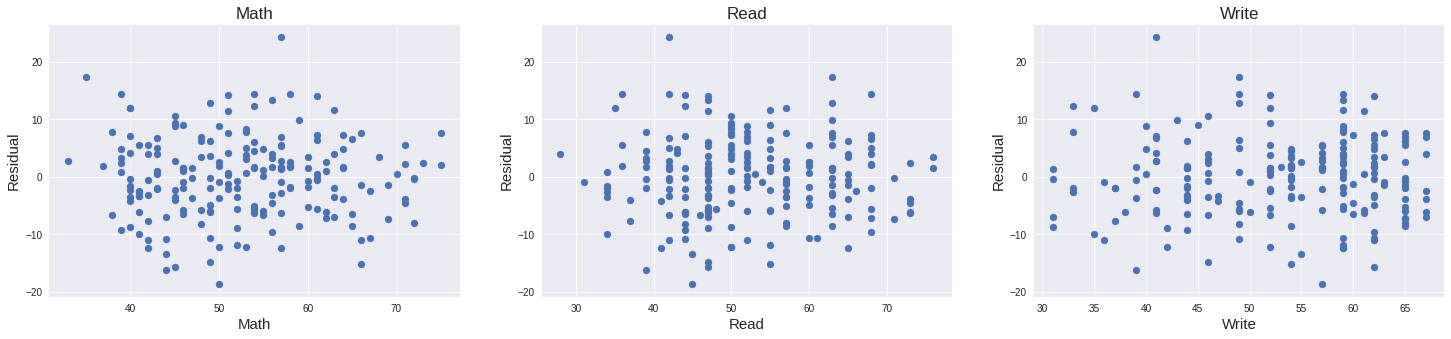

In [15]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.scatter(y=residuals, x=grades['math'])
plt.title('Math', fontsize=17)
plt.ylabel('Residual', fontsize=15)
plt.xlabel('Math', fontsize=15)

plt.subplot(1,3,2)
plt.scatter(y=residuals, x=grades['read'])
plt.title('Read', fontsize=17)
plt.ylabel('Residual', fontsize=15)
plt.xlabel('Read', fontsize=15)

plt.subplot(1,3,3)
plt.scatter(y=residuals, x=grades['write'])
plt.title('Write', fontsize=17)
plt.ylabel('Residual', fontsize=15)
plt.xlabel('Write', fontsize=15)

plt.show()

in case we detect that any of these graphs contains a non-randomess, for example in `write` there are more observations in the high values that in the low ones, we should regress the absolute value of the residuals to that variable

In [16]:
aux_data=pd.DataFrame({'resid': abs_resids, 'write': grades['write']})
aux_model = ols('resid ~ write', data=aux_data).fit()

print(aux_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.4965
Date:                Wed, 17 Mar 2021   Prob (F-statistic):              0.482
Time:                        10:03:04   Log-Likelihood:                -577.21
No. Observations:                 200   AIC:                             1158.
Df Residuals:                     198   BIC:                             1165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6822      1.748      3.824      0.0

Glesjer test implies that if the coefficients of this model are significant then there is a problem with heteroskedasticity (not in this case since it is irrelevant). What we should consider a **weighted least squares** approach. For this let's first define the y and the x from our dataset (a step needed jsut to add the intercept to the resgression model)

In [25]:
y=grades['science']
x=grades[['read','write','math']]
x = sm.add_constant(x)              # adding the intercept

now we can fit the model

In [26]:
weights = abs(aux_model.fittedvalues)**(-1) # other options include the power squared instead of linear

we_model = sm.WLS(y, x, weights).fit()
print(we_model.summary())

                            WLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.499
Model:                            WLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     65.00
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           3.23e-29
Time:                        10:11:18   Log-Likelihood:                -672.08
No. Observations:                 200   AIC:                             1352.
Df Residuals:                     196   BIC:                             1365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5558      3.212      2.664      0.0

you see that the model does not change the coefficients significantly but now it is protected against heteroskedasticity. 

The idea behind the weights is that these must be the inverse of the variances of the error in each observation. These variances can be estimated from different regressions for the residuals, then a possible set of rules may be the following:

 * A funnel shape in the plot of residuals vs. predictor or vs. fitted values, then we regress the absolute value of the residuals on that predictor or on those fitted values and the fitted values of this regression can be taken as estimates of the standard deviation of the errors, $\sigma_i$, then we take $w_i=1/\sigma_i^2$.
 * If we detect an upward trend on a fit of the squared residuals vs. predictor or vs. fitted values, we regress the squared residuals on that predictor or on those fitted values and the fitted values of this regression can be taken as estimates of the variance of the errors, $\sigma_i^2$, then we take $w_i=1/\sigma_i^2$.


### Autocorrelation

Serial correlation takes the form

$$
e_t = \rho\, e_{t-1} + u_t
$$

and no autocorrelation may imply that 

$$
H_0:\{\rho = 0\}
$$

let's fit this model and test the relevancy of the lagged variable

In [16]:
residuals_df = pd.DataFrame({'residuals': residuals,
                             'lag_residuals': residuals.shift()})
ac_model = ols('residuals ~ lag_residuals', data=residuals_df).fit()
print(ac_model.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3075
Date:                Tue, 16 Mar 2021   Prob (F-statistic):              0.580
Time:                        15:59:02   Log-Likelihood:                -669.43
No. Observations:                 199   AIC:                             1343.
Df Residuals:                     197   BIC:                             1349.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0104      0.498      0.021

#### Durbin-Watson Statistic

Durbin and Watson found an statistic that can be used to test autocorrelation without the need of any auxiliar regression

$$
DW=\frac{\sum (\hat e_t - \hat e_{t-1})^2}{\sum \hat e_t^2}\approx 2(1-\rho)
$$

Then following this approximation we may conclude that

 * if $\rho = 0$, then $DW\approx 2$, then we are led to conclude that as soon as the DW statistic is around 2, there is no autocorrelation. However, the denominator in the previous statistic does not let us be too precise with the approximation.

The proper interpretation of the DW Statistic comes using two boundary values for it: $(d_L, d_U)$, such that

 * If $DW > d_U$, we fail to reject the NULL and conclude that there is no autocorrelation
 * If $DW < d_L$, we reject the NULL hypothesis in favor of $H_1:\{\rho > 0\}$, so positive autocorrelation
 * IF $d_L < DW < d_U$, the test is inconclusive.


In our case the statistic is $1.952$, and the limits are $(1.098, 1.442)$, then the statistic is larger than $d_U$ and we do not find any problems with autocorrelation.

## Categorical Variables

In [17]:
# Models -------------------------------------------------------------------------------------------------
pooled_model = ols('science ~ math + read + write', data = grades).fit()
fem_model = ols('science ~ math + read + write', data = grades[grades['gender'] == 'female']).fit()
male_model = ols('science ~ math + read + write', data = grades[grades['gender'] == 'male']).fit()

# Data ---------------------------------------------------------------------------------------------------
n = pooled_model.nobs
K = len(pooled_model.model.exog[0])-1

# Sum of Squared Residuals -------------------------------------------------------------------------------
RSSp = sum(pooled_model.resid**2)
RSSf = sum(fem_model.resid**2)
RSSm = sum(male_model.resid**2)

# F-statistic --------------------------------------------------------------------------------------------
Fstat_1 = (RSSp - (RSSf + RSSm))/(RSSf + RSSm)*(n-2*(K+1))/(K+1)
Fstat_2 = (RSSp - (RSSf + RSSm))/(RSSf + RSSm)*(n-2*(K+1))/(K)

# p-value ------------------------------------------------------------------------------------------------
pval_1 = ss.f.sf(Fstat_1, K+1, n-2*(K+1))
pval_2 = ss.f.sf(Fstat_2, K, n-2*(K+1))

print(pval_1, pval_2)

0.007212159877396263 0.0029186458929938318


the model we are considering

$$
y_i = \beta_0 + \beta_1\, x_1 + \beta_2 x_2 + \delta_1\,\text{cat} + \delta_2\, x_2\cdot \text{cat} + \delta_3\, x_3\cdot \text{cat} 
$$

then the NULL hypothesis we work with are

$$
H_0:\{\delta_1=0, \delta_2=0,\delta_3=0\}
$$

in the first case ($K+1$), and 

$$
H_0:\{ \delta_2=0,\delta_3=0\}
$$

in the second case ($K$). Then:

 * The first p-value is $0.0072$, then in this case we reject $H_0$(for a 1% of SL)
 * The second p-value is $0.014$, then in this case we fail to reject $H_0$ (for a 1% of SL)

Then we should only include `gender` and not its interactions in the model


In [18]:
mymodel = ols('science ~ math + read + write + C(gender)', data = grades).fit()
print(mymodel.summary())

                            OLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     54.42
Date:                Tue, 16 Mar 2021   Prob (F-statistic):           9.43e-31
Time:                        15:59:11   Log-Likelihood:                -666.84
No. Observations:                 200   AIC:                             1344.
Df Residuals:                     195   BIC:                             1360.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.7215      3.21

In [19]:
# Models -------------------------------------------------------------------------------------------------
pooled_model = ols('science ~ math + read + write + C(gender)', data = grades).fit()
fem_model = ols('science ~ math + read + write + C(gender)', data = grades[grades['schtyp'] == 'public']).fit()
male_model = ols('science ~ math + read + write + C(gender)', data = grades[grades['schtyp'] == 'private']).fit()

# Data ---------------------------------------------------------------------------------------------------
n = pooled_model.nobs
K = len(pooled_model.model.exog[0])-1

# Sum of Squared Residuals -------------------------------------------------------------------------------
RSSp = sum(pooled_model.resid**2)
RSSf = sum(fem_model.resid**2)
RSSm = sum(male_model.resid**2)

# F-statistic --------------------------------------------------------------------------------------------
Fstat_1 = (RSSp - (RSSf + RSSm))/(RSSf + RSSm)*(n-2*(K+1))/(K+1)
Fstat_2 = (RSSp - (RSSf + RSSm))/(RSSf + RSSm)*(n-2*(K+1))/(K)

# p-value ------------------------------------------------------------------------------------------------
pval_1 = ss.f.sf(Fstat_1, K+1, n-2*(K+1))
pval_2 = ss.f.sf(Fstat_2, K, n-2*(K+1))

print(pval_1, pval_2)

0.8940421402251817 0.7989574834067309


In [20]:
mymodel = ols('science ~ math + read + write + C(gender)', data = grades).fit()
print(mymodel.summary())

                            OLS Regression Results                            
Dep. Variable:                science   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     54.42
Date:                Tue, 16 Mar 2021   Prob (F-statistic):           9.43e-31
Time:                        15:59:19   Log-Likelihood:                -666.84
No. Observations:                 200   AIC:                             1344.
Df Residuals:                     195   BIC:                             1360.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.7215      3.21

## ANOVA

Let's find out if there is a significant difference between the grades in Math depending on your Program

In [21]:
grades['prog'].unique()

array(['general', 'vocational', 'academic'], dtype=object)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


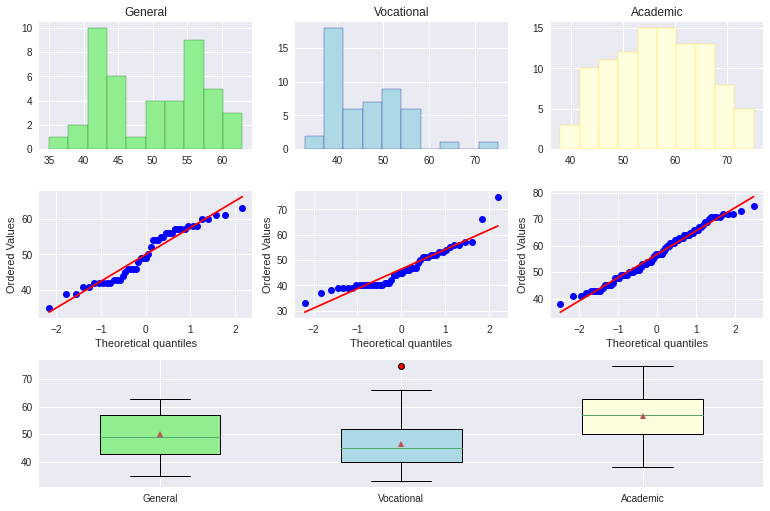

In [22]:
'''
The following procedure is a bit long and could be simplified
using a for loop to generate the different graphs
'''

plt.figure(figsize = (12,8))

# Histograms ------------------------------------------
plt.subplot2grid((3,3), (0,0))
plt.hist(grades[grades['prog']=='general']['math'],
         color = 'lightgreen',
         ec = 'Darkgreen')
plt.title('General')

plt.subplot2grid((3,3), (0,1))
plt.hist(grades[grades['prog']=='vocational']['math'],
         color = 'lightblue',
         ec = 'Darkblue')
plt.title('Vocational')

plt.subplot2grid((3,3), (0,2))
plt.hist(grades[grades['prog']=='academic']['math'],
         color = 'lightyellow',
         ec = 'gold')
plt.title('Academic')

# QQplots ------------------------------------------
plt.subplot2grid((3,3), (1,0))
ss.probplot(grades[grades['prog']=='general']['math'],
            dist = 'norm',
            plot = plt)
plt.title('')

plt.subplot2grid((3,3), (1,1))
ss.probplot(grades[grades['prog']=='vocational']['math'],
            dist = 'norm',
            plot = plt)
plt.title('')

plt.subplot2grid((3,3), (1,2))
ss.probplot(grades[grades['prog']=='academic']['math'],
            dist = 'norm',
            plot = plt)
plt.title('')

# Boxplots ------------------------------------------
plt.subplot2grid((3,3), (2,0), colspan=3)
bp =plt.boxplot([grades[grades['prog']=='general']['math'],
                 grades[grades['prog']=='vocational']['math'],
                 grades[grades['prog']=='academic']['math']],
                showmeans = True,
                patch_artist = True,
                widths = 0.5,
                flierprops = dict(marker = 'o',
                                  markerfacecolor = 'red'),
                labels = ['General', 'Vocational', 'Academic']
                )
colors = ['lightgreen', 'lightblue', 'lightyellow']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.tight_layout(rect = (0,0,0.9,0.9))
plt.show()

To test the homoskedasticity we may use Bartlett test, however it needs the levels in `prog` as numbers, then we are going to use Levene.

In [23]:
ss.levene(grades['math'][grades['prog']=='general'],
          grades['math'][grades['prog']=='vocational'],
          grades['math'][grades['prog']=='academic'])

LeveneResult(statistic=1.1576839472045344, pvalue=0.31634130188841664)

since the p-value is 0.32, we do not find evidence against homoskedasticity and all the variances can be assumed to be equal.

Let's fit the ANOVA model

In [24]:
model = ols('math ~ C(prog)', data=grades).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(prog),4002.103889,2.0,29.279284,7.364011e-12
Residual,13463.691111,197.0,NaN,NaN


From the table we see that the p-value is way smaller than the 5% and then we reject the NULL hypothesis and then we find evidence against the equality of means (the variable/model is relevant to explain the variability in the response). 

This implies that we need to perform a post-hoc analysis

In [26]:
mc = MultiComparison(grades['math'], grades['prog'])

In [27]:
print('{:^59s}'.format('Tukey'))
print('='*59)
print()
print(mc.tukeyhsd())

print('\n\n{:^59s}'.format('Bonferroni'))
print('='*59)
print()
print(mc.allpairtest(ss.ttest_ind, method='bonferroni', alpha=0.05)[0])

                           Tukey                           

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2   meandiff p-adj   lower    upper  reject
-----------------------------------------------------------
academic    general  -6.7111  0.001 -10.1899 -3.2324   True
academic vocational -10.3133  0.001 -13.6681 -6.9585   True
 general vocational  -3.6022 0.0882  -7.6141  0.4097  False
-----------------------------------------------------------


                        Bonferroni                         

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonferroni
alphacSidak=0.02, alphacBonf=0.017
 group1    group2    stat   pval  pval_corr reject
--------------------------------------------------
academic    general 4.5012    0.0       0.0   True
academic vocational 7.0703    0.0       0.0   True
 general vocational 2.2719 0.0254    0.0762  False
--------------------------------------------------


In [28]:
grades.groupby('prog')['math'].mean()

prog
academic      56.733333
general       50.022222
vocational    46.420000
Name: math, dtype: float64

## Influential Points

Let's find the outliers, leverage and influential points (if any)

In [59]:
influential = model.get_influence()
inf_data = influential.summary_frame()
inf_data.head()

,dfb_Intercept,dfb_read,dfb_write,dfb_math,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.015909,-0.037873,-0.008502,0.051037,0.000874,-0.347023,0.028210,-0.059125,-0.346243,-0.058992
1,-0.026531,0.095697,0.008769,-0.065829,0.003387,0.717430,0.025644,0.116390,0.716539,0.116245
2,0.160805,-0.043513,-0.326529,0.229585,0.036587,1.780870,0.044109,0.382553,1.790869,0.384701
3,0.009619,0.035872,-0.021942,-0.017246,0.000439,0.218735,0.035385,0.041894,0.218203,0.041792
4,0.001578,-0.015109,-0.001938,0.015845,0.000140,0.213610,0.012157,0.023697,0.213090,0.023639


let me store the information in separated arrays

In [98]:
std_resids = inf_data['student_resid']
stda_resids = inf_data['standard_resid']
leverage = inf_data['hat_diag']
cooks = inf_data['cooks_d']
dffits = inf_data['dffits']

### Outliers

In [61]:
tcrit = abs(ss.t.ppf(0.05/(2*n), n-K-1))
outliers = [i for i in std_resids if i >= tcrit]
std_resids.index[std_resids > tcrit]

Int64Index([], dtype='int64')

### Leverage

In [69]:
boundary = 2*(K+1)/n
high_lever = [i for i in leverage if i >= boundary]
leverage.index[leverage > boundary]

Int64Index([2, 20, 30, 31, 36, 88], dtype='int64')

### Influential Points

In [68]:
D = 4/(n-K-1)
influ = [i for i in cooks if i >= D]
cooks.index[cooks > D]

Int64Index([2, 14, 20, 33, 55, 61, 81, 91, 105, 110, 124, 193], dtype='int64')

In [112]:
DF = 2*np.sqrt((K+2)/(n-K-2))
influ = [i for i in dffits if i > DF]
dffits.index[abs(dffits) > DF]

Int64Index([2, 20, 33, 61, 81, 105, 124, 193], dtype='int64')

In [107]:
dffits[124]

-0.3867858467011827

### Graphical Analysis

Let's begin with the residuals plot

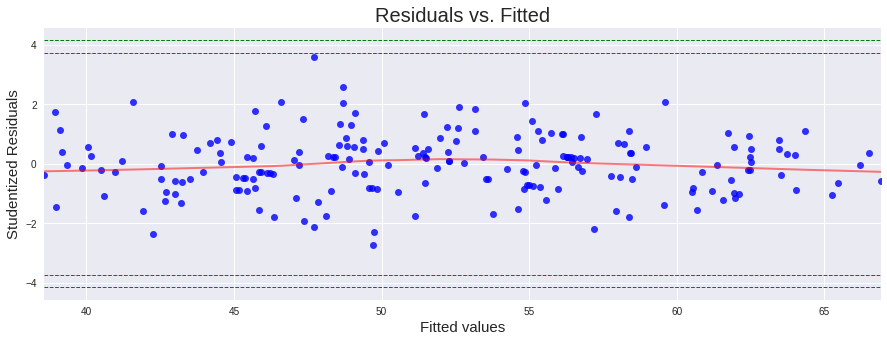

In [81]:
plt.figure(figsize = (15,5))
sns.regplot(x = fitted, y = std_resids,
            scatter = True,
            lowess = True,
            scatter_kws = {'color': 'blue'},
            line_kws = {'color': 'red', 'lw': 2, 'alpha': 0.5})

plt.title("Residuals vs. Fitted", fontsize = 20)
plt.xlabel('Fitted values', fontsize = 15)
plt.ylabel('Studentized Residuals', fontsize = 15)

plt.hlines(ss.t.ppf(0.05/(2*n), n-K-1), min(fitted), max(fitted), color = "red", linestyles='--', linewidth = 1)
plt.hlines(ss.t.isf(0.05/(2*n), n-K-1), min(fitted), max(fitted), color = "red", linestyles='--', linewidth = 1)
plt.hlines(ss.t.ppf(0.01/(2*n), n-K-1), min(fitted), max(fitted), color = "green", linestyles='--', linewidth = 1)
plt.hlines(ss.t.isf(0.01/(2*n), n-K-1), min(fitted), max(fitted), color = "green", linestyles='--', linewidth = 1)
plt.show()

we have added the boundaries for the confidence intervals to denote one outlier and, as expected from the analytical case, we do not detect any outlier.

In order to find influential points, we can use two graphs. On one hand a plot Standarized Residuals vs. Leverage, in this plot we can use that

$$
D_i=\frac{{\hat e_i^{st}}^2}{K+1}\frac{h_i}{1-h_i}
$$

from where the boundary for $D$ can be found by just solving for $\hat e_i^{st}$ as a function of $h_i$

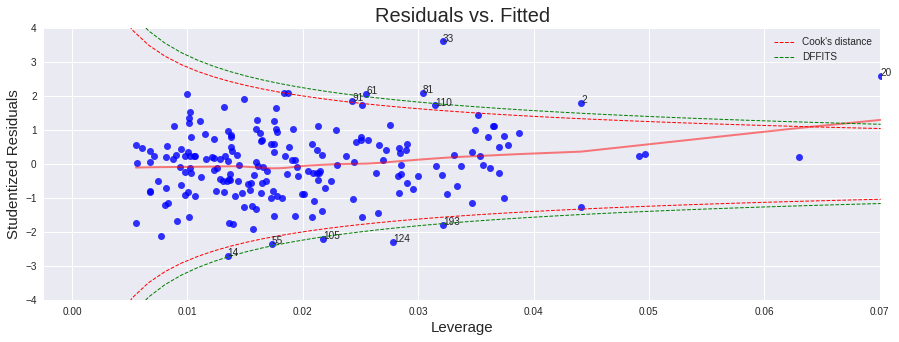

In [113]:
# Let's use an auxiliar function to plot the Cook's Boundaries
def graph(formula, x_range, label = None, color = None):
  x = x_range
  y = formula(x)
  plt.plot(x, y, label = label, lw = 1, ls = '--', color = color)

# Now we begin with the plot itself
plt.figure(figsize = (15, 5))
sns.regplot(x=leverage, y=std_resids,
            scatter = True,
            lowess = True,
            scatter_kws = {'color': 'blue'},
            line_kws = {'color': 'red', 'lw': 2, 'alpha': 0.5})

plt.title("Residuals vs. Fitted", fontsize = 20)
plt.xlabel('Leverage', fontsize = 15)
plt.ylabel('Studentized Residuals', fontsize = 15)

cooks_top = cooks.sort_values(ascending=False)[:12]
for i in cooks_top.index:
  plt.annotate(i, xy = (leverage[i],
                        std_resids[i]))

graph(lambda x: np.sqrt((D*(K+1)*(1-x))/x), np.linspace(0.001, max(leverage), 50), 'Cook\'s distance', 'red')
graph(lambda x: -np.sqrt((D*(K+1)*(1-x))/x), np.linspace(0.001, max(leverage), 50), color = 'red')

graph(lambda x: DF*np.sqrt((1-x)/x), np.linspace(0.001, max(leverage), 50), 'DFFITS', 'green')
graph(lambda x: -DF*np.sqrt((1-x)/x), np.linspace(0.001, max(leverage), 50), color='green')

plt.legend(loc = 'best')
plt.ylim(-4,4)

plt.show()

 Note that in this graph most of the observations fall inside the region defined by the boundaries and that all but two of the observations are in a close region to those boundaries. We can see this more clearly with the following graphs

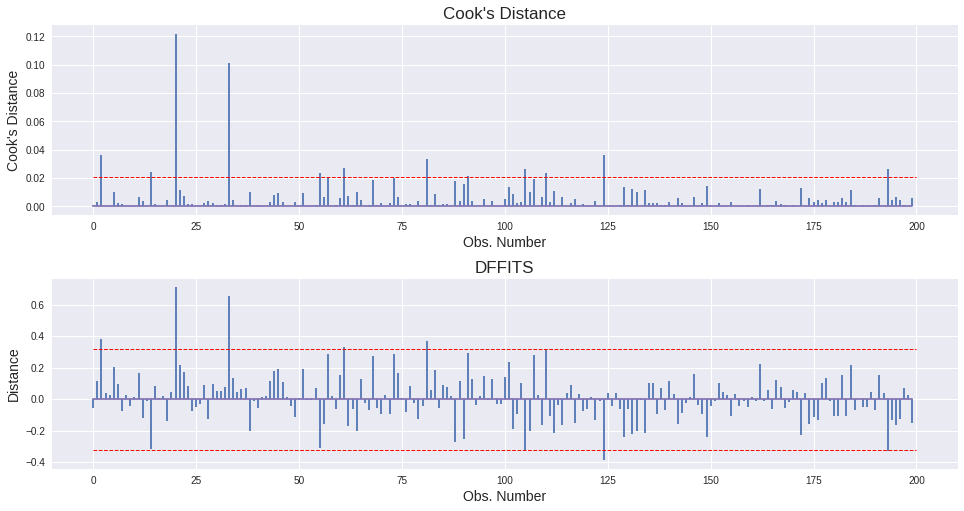

In [114]:
plt.figure(figsize = (15,8))

plt.subplot(2,1,1)
plt.stem(cooks, markerfmt=' ',
         use_line_collection=True)
plt.hlines(D, 0, n, color = "red", linestyles='--', linewidth = 1)

plt.title('Cook\'s Distance', fontsize=17)
plt.xlabel('Obs. Number', fontsize=14)
plt.ylabel('Cook\'s Distance', fontsize=14)

plt.subplot(2,1,2)
plt.stem(dffits, markerfmt=' ',
         use_line_collection=True)
plt.hlines(DF, 0, n, color = "red", linestyles='--', linewidth = 1)
plt.hlines(-DF, 0, n, color = "red", linestyles='--', linewidth = 1)

plt.title('DFFITS', fontsize=17)
plt.xlabel('Obs. Number', fontsize=14)
plt.ylabel('Distance', fontsize=14)

plt.tight_layout(rect=(0,0,0.9,0.9))
plt.show()

where the red lines denote the boundaries. Now, remember that these boundaries are not hard-ones in the sense that they are more some guidelines. Then, we may only be *worried* by those observations that truly pick out of the charts. Specifically in our case observations with indices 20 and 33, let's see them

In [117]:
grades.iloc[[20,33]]

,id,gender,race,ses,schtyp,prog,read,write,math,science,socst,compr
20,167,male,white,middle,public,general,63,49,35,66,41,112
33,150,male,white,middle,public,vocational,42,41,57,72,31,83


In [116]:
fitted.iloc[[20,33]]

20    48.688941
33    47.722776
dtype: float64

we can immediately see why the observations are influential, observation 33, for example, has low grades in all the exams but in science, our prediction for him would be 47.72 while he obtained 72. On the other hand observation 20 had a 66 while our prediction is 48.69.